# Assignment 1 - Problem 2: Logistic Regression

Build a logistic regression model to predict whether someone has coronary heart disease

In the data folder on the class's GitHub repo, you will find heart.txt. The first row is the name of the observed variables. There are 10 vars:
* sbp: Systolic blood pressure
* tobacco: Cumulative tobacco consumption, in kg
* ldl: Low-density liboprotein cholestrol
* adiposity: Adipose tissue concentration
* famhist: Family history of heart disease (1=Present, 0=Absent)
* typea: Score on test designed to measure type-A behavior
* obesity: Obesity
* alcohol: Current consumption of alcohol
* age: Age of subject
* chd: Coronary heart disease at baseline; 1=Yes 0=No

Each row contains one patient. There are 462 samples in total. You will be using the first 9 variables to predict the last variable. That is, your input will be 1-d tensor of 9 elements, and your label is binary. You should write the function to read in data yourself, and you should take care of dividing your data into train set and test set.

Report your results and your hyperparameters.

## Task 3

In [45]:
import csv
import numpy as np
from sklearn.utils import shuffle # Shuffles multiple arrays in a consistent way

""" Load dataset from tab-separated values file to array """
dataset = []
with open("data/heart.txt") as tsv:
    for line in csv.reader(tsv, dialect="excel-tab"):
        if (line[4] == 'Present'): # Convert famhist from Present/Absent to 1/0
            line[4] = 1
        elif (line[4] == 'Absent'):
            line[4] = 0
        dataset.append(line)
dataset = dataset[1:] # Remove header: ['sbp', 'tobacco', ...]

""" Convert dataset to a numpy array """
dataset = np.array(dataset, dtype = np.float32)

""" Prepare dataset """
shuffle(dataset)
n = len(dataset)
validation_start_idx = int(6 * n / 10)
test_start_idx = int(8 * n / 10)

""" Split dataset """
training = dataset[:validation_start_idx]
validation = dataset[validation_start_idx:test_start_idx]
test = dataset[test_start_idx:]

In [46]:
X_data = training[:, :9]
Y_data = training[:, 9]

X_validation_data = validation[:, :9]
Y_validation_data = validation[:, 9]
    
X_test_data = test[:, :9]
Y_test_data = test[:, 9]

In [47]:
import tensorflow as tf

learning_rate = 0.000001
batch_size = 1
n_epochs = 200
display_step = 10

X = tf.placeholder(tf.float32, [batch_size, 9])
Y = tf.placeholder(tf.float32, [batch_size, 1])

w = tf.Variable(tf.random_normal(shape = [9, 1], 
                                 stddev = tf.divide(tf.constant(1.0), 
                                                    tf.sqrt(tf.to_float(n))), 
                                 name = "weights"))
b = tf.Variable(tf.zeros([1, 1]), name = "bias")
                
logits = tf.matmul(X, w) + b
                
entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = Y)
loss = tf.reduce_mean(entropy)
                
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

init = tf.global_variables_initializer()

Epoch: 0010 cost= 0.457957871
Epoch: 0020 cost= 0.439646483
Epoch: 0030 cost= 0.425174651
Epoch: 0040 cost= 0.413752458
Epoch: 0050 cost= 0.405909729
Epoch: 0060 cost= 0.400188191
Epoch: 0070 cost= 0.395126302
Epoch: 0080 cost= 0.392532732
Epoch: 0090 cost= 0.390646891
Epoch: 0100 cost= 0.388190340
Epoch: 0110 cost= 0.387582984
Epoch: 0120 cost= 0.386398633
Epoch: 0130 cost= 0.385535284
Epoch: 0140 cost= 0.384302317
Epoch: 0150 cost= 0.383438827
Epoch: 0160 cost= 0.382796705
Epoch: 0170 cost= 0.381411431
Epoch: 0180 cost= 0.381304286
Epoch: 0190 cost= 0.380471434
Epoch: 0200 cost= 0.379730685


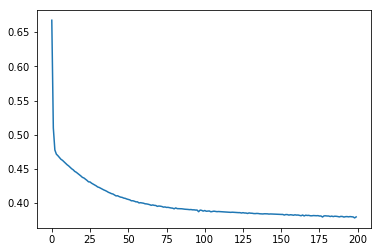

Validation Accuracy 0.6413043478260869
Accuracy 0.6129032258064516


In [48]:
import matplotlib.pyplot as plt

with tf.Session() as sess:
    sess.run(init)
    n_batches = int(n/batch_size)
    costs = []
    for i in range(n_epochs):
        avg_cost = 0
        X_data, Y_data = shuffle(X_data, Y_data)
        for batch_num in range(n_batches):
            X_batch = X_data[batch_num * batch_size:(batch_num + 1) * batch_size]
            if (np.shape(X_batch)[0] == batch_size): # Ignore the remaining training data that don't divide into batch_size
                Y_batch = Y_data[batch_num * batch_size:(batch_num + 1) * batch_size].reshape(batch_size, 1)
                _, loss_batch = sess.run([optimizer, loss], feed_dict = {X: X_batch, Y: Y_batch})
                avg_cost += loss_batch / n_batches
        costs.append(avg_cost)
        if (i+1) % display_step == 0:
            print("Epoch:", '%04d' % (i+1), "cost=", "{:.9f}".format(avg_cost))
    plt.plot(costs)
    plt.show()
    # Validate the model 
    total_correct_preds_valid = 0
    count_valid = 0
    for batch_num in range(n_batches):
        X_batch = X_validation_data[batch_num * batch_size:(batch_num + 1) * batch_size]
        if (np.shape(X_batch)[0] == batch_size): # Ignore the remaining test data that don't divide into batch_size
            Y_batch = Y_validation_data[batch_num * batch_size:(batch_num + 1) * batch_size].reshape(batch_size, 1)
            _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict = {X: X_batch, Y: Y_batch})
            preds = tf.nn.sigmoid(logits_batch)
            correct_preds = tf.equal(tf.round(preds), tf.round(Y_batch))
            accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
            total_correct_preds_valid += sess.run(accuracy)
            count_valid += batch_size
    print("Validation Accuracy {0}".format(total_correct_preds_valid/count_valid))
    # Test the model
    total_correct_preds = 0
    count = 0
    for batch_num in range(n_batches):
        X_batch = X_test_data[batch_num * batch_size:(batch_num + 1) * batch_size]
        if (np.shape(X_batch)[0] == batch_size): # Ignore the remaining test data that don't divide into batch_size
            Y_batch = Y_test_data[batch_num * batch_size:(batch_num + 1) * batch_size].reshape(batch_size, 1)
            _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict = {X: X_batch, Y: Y_batch})
            preds = tf.nn.sigmoid(logits_batch)
            correct_preds = tf.equal(tf.round(preds), tf.round(Y_batch))
            accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
            total_correct_preds += sess.run(accuracy)
            count += batch_size
    print("Accuracy {0}".format(total_correct_preds/count))

## Logistic regression with one-hot encoding: Does it perform better?

## Benefits of one-hot encoding
https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor

You express [dog,cat,dog,mouse,cat] as [1,2,1,3,2], but then the average of dog and mouse is cat.

The benefit of one-hot encoding is that everything sits in an orthogonal vector space.

For this problem, the label is already binary: has or not has coronary heart disease. It's not clear if one-hot encoding would affect performance.

In [50]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(np.split(dataset[:, 9], len(dataset))) # The encoder will "fit" the enumeration of possible y values

""" Convert dataset to a numpy array """
dataset = np.array(dataset, dtype = np.float32)

""" Convert to one-hot encoding """
X_data = dataset[:, :9]
Y_data = enc.transform(np.split(dataset[:, 9], len(dataset))).toarray()

""" Prepare dataset """
shuffle(X_data, Y_data)
n = len(X_data)
validation_start_idx = int(6 * n / 10)
test_start_idx = int(8 * n / 10)

""" Split dataset """
X_training = X_data[:validation_start_idx]
X_validation = X_data[validation_start_idx:test_start_idx]
X_test = X_data[test_start_idx:]
Y_training = Y_data[:validation_start_idx]
Y_validation = Y_data[validation_start_idx:test_start_idx]
Y_test = Y_data[test_start_idx:]

In [70]:
import tensorflow as tf

learning_rate = 0.000001
batch_size = 1
n_epochs = 200
display_step = 10

X = tf.placeholder(tf.float32, [batch_size, 9])
Y = tf.placeholder(tf.float32, [batch_size, 2])

w = tf.Variable(tf.random_normal(shape = [9, 2], 
                                 stddev = tf.divide(tf.constant(1.0), 
                                                    tf.sqrt(tf.to_float(n))), 
                                 name = "weights"))
b = tf.Variable(tf.zeros([1, 2]), name = "bias")
                
logits = tf.matmul(X, w) + b
                
entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = Y)
loss = tf.reduce_mean(entropy)
                
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

init = tf.global_variables_initializer()

Epoch: 0010 cost= 0.431772394
Epoch: 0020 cost= 0.419078763
Epoch: 0030 cost= 0.408095386
Epoch: 0040 cost= 0.401113304
Epoch: 0050 cost= 0.394921375
Epoch: 0060 cost= 0.389453553
Epoch: 0070 cost= 0.385053512
Epoch: 0080 cost= 0.380813056
Epoch: 0090 cost= 0.377343726
Epoch: 0100 cost= 0.375935849
Epoch: 0110 cost= 0.373361611
Epoch: 0120 cost= 0.370868697
Epoch: 0130 cost= 0.367948116
Epoch: 0140 cost= 0.367973625
Epoch: 0150 cost= 0.365911855
Epoch: 0160 cost= 0.364983325
Epoch: 0170 cost= 0.365148028
Epoch: 0180 cost= 0.364312570
Epoch: 0190 cost= 0.364125625
Epoch: 0200 cost= 0.362938181


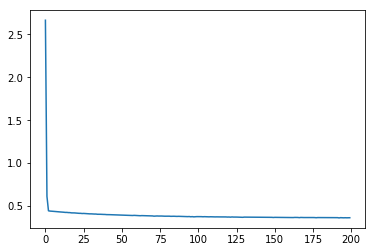

Validation Accuracy 0.7065217391304348
Accuracy 0.6344086021505376


In [73]:
import matplotlib.pyplot as plt

with tf.Session() as sess:
    sess.run(init)
    n_batches = int(n/batch_size)
    costs = []
    for i in range(n_epochs):
        avg_cost = 0
        X_training, Y_training = shuffle(X_training, Y_training)
        for batch_num in range(n_batches):
            X_batch = X_training[batch_num * batch_size:(batch_num + 1) * batch_size]
            if (np.shape(X_batch)[0] == batch_size): # Ignore the remaining training data that don't divide into batch_size
                Y_batch = Y_training[batch_num * batch_size:(batch_num + 1) * batch_size]
                _, loss_batch = sess.run([optimizer, loss], feed_dict = {X: X_batch, Y: Y_batch})
                avg_cost += loss_batch / n_batches
        costs.append(avg_cost)
        if (i+1) % display_step == 0:
            print("Epoch:", '%04d' % (i+1), "cost=", "{:.9f}".format(avg_cost))
    plt.plot(costs)
    plt.show()
    # Validate the model 
    total_correct_preds_valid = 0
    count_valid = 0
    for batch_num in range(n_batches):
        X_batch = X_validation[batch_num * batch_size:(batch_num + 1) * batch_size]
        if (np.shape(X_batch)[0] == batch_size): # Ignore the remaining test data that don't divide into batch_size
            Y_batch = Y_validation[batch_num * batch_size:(batch_num + 1) * batch_size]
            _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict = {X: X_batch, Y: Y_batch})
            preds = tf.nn.softmax(logits_batch)
            correct_preds = tf.equal(tf.argmax(preds, axis=1), tf.argmax(Y_batch, axis=1))
            accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
            total_correct_preds_valid += sess.run(accuracy)
            count_valid += batch_size
    print("Validation Accuracy {0}".format(total_correct_preds_valid/count_valid))
    # Test the model
    total_correct_preds = 0
    count = 0
    for batch_num in range(n_batches):
        X_batch = X_test[batch_num * batch_size:(batch_num + 1) * batch_size]
        if (np.shape(X_batch)[0] == batch_size): # Ignore the remaining test data that don't divide into batch_size
            Y_batch = Y_test[batch_num * batch_size:(batch_num + 1) * batch_size]
            _, loss_batch, logits_batch = sess.run([optimizer, loss, logits], feed_dict = {X: X_batch, Y: Y_batch})
            preds = tf.nn.softmax(logits_batch)
            correct_preds = tf.equal(tf.argmax(preds, axis=1), tf.argmax(Y_batch, axis=1))
            accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
            total_correct_preds += sess.run(accuracy)
            count += batch_size
    print("Accuracy {0}".format(total_correct_preds/count))

# Conclusion
Logistic regression with tuned parameters and without one-hot encoding achieves 61.29% test accuracy.

Logistic regression with tuned parameters and with one-hot encoding achieves 63.44% test accuracy.